# Bayes rule with Gaussians

__Content creators:__ Vincent Valton, Konrad Kording, with help from Matt Krause

__Content reviewers:__ Matt Krause, Jesse Livezey, Karolina Stosio, Saeed Salehi, Michael Waskom

# Tutorial Objectives
This is the first in a series of three main tutorials (+ one bonus tutorial) on Bayesian statistics. In these tutorials, we will develop a Bayesian model for localizing sounds based on audio and visual cues. This model will combine **prior** information about where sounds generally originate with sensory information about the **likelihood** that a specific sound came from a particular location. As we will see in subsequent lessons, the resulting **posterior distribution** not only allows us to make optimal decision about the sound's origin, but also lets us quantify how uncertain that decision is. Bayesian techniques are therefore useful **normative models**: the behavior of human or animal subjects can be compared against these models to determine how efficiently they make use of information. 

This notebook will introduce two fundamental building blocks for Bayesian statistics: the Gaussian distribution and the Bayes Theorem. You will: 

1. Implement a Gaussian distribution
2. Use Bayes' Theorem to find the posterior from a Gaussian-distributed prior and likelihood. 
3. Change the likelihood mean and variance and observe how posterior changes.
4. Advanced (*optional*): Observe what happens if the prior is a mixture of two gaussians?


Video available at https://youtube.com/watch?v=K4sSKZtk-Sc


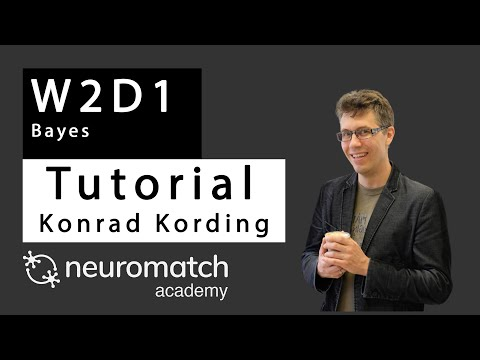

In [1]:
#@title Video 1: Introduction to Bayesian Statistics
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='K4sSKZtk-Sc', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Setup  
Please execute the cells below to initialize the notebook environment.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Figure Settings
import ipywidgets as widgets
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
#@title Helper functions
def my_plot_single(x, px):
    """
    Plots normalized Gaussian distribution

    Args:
        x (numpy array of floats):     points at which the likelihood has been evaluated
        px (numpy array of floats):    normalized probabilities for prior evaluated at each `x`

    Returns:
        Nothing.
    """
    if px is None:
        px = np.zeros_like(x)

    fig, ax = plt.subplots()
    ax.plot(x, px, '-', color='C2', LineWidth=2, label='Prior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')


def posterior_plot(x, likelihood=None, prior=None, posterior_pointwise=None, ax=None):
    """
    Plots normalized Gaussian distributions and posterior

    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
        visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        ax: Axis in which to plot. If None, create new axis.

    Returns:
        Nothing.
    """
    if likelihood is None:
        likelihood = np.zeros_like(x)

    if prior is None:
        prior = np.zeros_like(x)

    if posterior_pointwise is None:
        posterior_pointwise = np.zeros_like(x)

    if ax is None:
      fig, ax = plt.subplots()

    ax.plot(x, likelihood, '-C1', LineWidth=2, label='Auditory')
    ax.plot(x, prior, '-C0', LineWidth=2, label='Visual')
    ax.plot(x, posterior_pointwise, '-C2', LineWidth=2, label='Posterior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')

    return ax


def plot_visual(mu_visuals, mu_posteriors, max_posteriors):
    """
    Plots the comparison of computing the mean of the posterior analytically and
    the max of the posterior empirically via multiplication.

    Args:
        mu_visuals (numpy array of floats): means of the visual likelihood
        mu_posteriors (numpy array of floats):  means of the posterior, calculated analytically
        max_posteriors (numpy array of floats): max of the posteriors, calculated via maxing the max_posteriors.
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`

    Returns:
        Nothing.
    """
    fig_w, fig_h = plt.rcParams.get('figure.figsize')
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(fig_w, 2 * fig_h))

    ax[0].plot(mu_visuals, max_posteriors, '-C2', label='mean')
    ax[0].set_xlabel('Visual stimulus position')
    ax[0].set_ylabel('Multiplied posterior mean')
    ax[0].set_title('Sample output')

    ax[1].plot(mu_visuals, mu_posteriors, '--', color='xkcd:gray', label='argmax')
    ax[1].set_xlabel('Visual stimulus position')
    ax[1].set_ylabel('Analytical posterior mean')
    fig.tight_layout()
    ax[1].set_title('Hurray for math!')


def multimodal_plot(x, example_prior, example_likelihood,
                    mu_visuals, posterior_modes):
  """Helper function for plotting Section 4 results"""

  fig_w, fig_h = plt.rcParams.get('figure.figsize')
  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(fig_w, 2*fig_h), sharex=True)

  # Plot the last instance that we tried.
  posterior_plot(x,
    example_prior,
    example_likelihood,
    compute_posterior_pointwise(example_prior, example_likelihood),
    ax=ax[0]
    )
  ax[0].set_title('Example combination')

  ax[1].plot(mu_visuals, posterior_modes, '-C2', label='argmax')
  ax[1].set_xlabel('Visual stimulus position\n(Mean of blue dist. above)')
  ax[1].set_ylabel('Posterior mode\n(Peak of green dist. above)')
  fig.tight_layout()

# Section 1: The Gaussian Distribution

Bayesian analysis operates on probability distributions. Although these can take many forms, the Gaussian distribution is a very common choice. Because of the central limit theorem, many quantities are Gaussian-distributed. Gaussians also have some mathematical properties that permit simple closed-form solutions to several important problems. 

In this exercise, you will implement a Gaussian by filling in the missing portion of `my_gaussian` below. Gaussians have two parameters. The **mean** $\mu$, which sets the location of its center. Its "scale" or spread is controlled by its **standard deviation** $\sigma$ or its square, the **variance** $\sigma^2$. (Be careful not to use one when the other is required). 

The equation for a Gaussian is:
$$
\mathcal{N}(\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)
$$
Also, don't forget that this is a probability distribution and should therefore sum to one. While this happens "automatically" when integrated from $-\infty$ to $\infty$, your version will only be computed over a finite number of points. You therefore need to explicitly normalize it yourself. 

Test out your implementation with a $\mu = -1$ and $\sigma = 1$. After you have it working, play with the  parameters to develop an intuition for how changing $\mu$ and $\sigma$ alter the shape of the Gaussian. This is important, because subsequent exercises will be built out of Gaussians. 

## Exercise 1: Implement a Gaussian

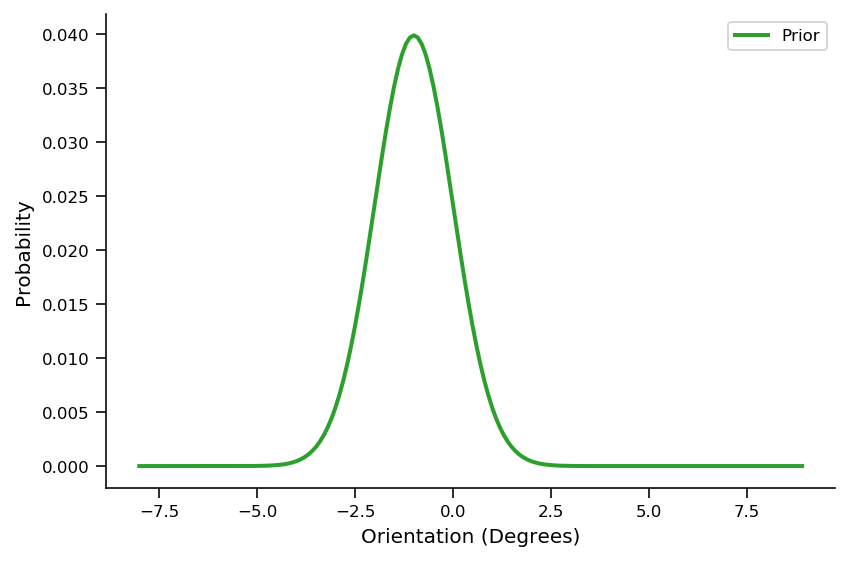

In [5]:
def my_gaussian(x_points, mu, sigma):
    """
    Returns normalized Gaussian estimated at points `x_points`, with parameters:
     mean `mu` and std `sigma`

    Args:
        x_points (numpy array of floats): points at which the gaussian is
                                          evaluated
        mu (scalar): mean of the Gaussian
        sigma (scalar): std of the gaussian

    Returns:
        (numpy array of floats) : normalized Gaussian evaluated at `x`
    """

    ###################################################################
    ## Add code to calcualte the gaussian px as a function of mu and sigma,
    ## for every x in x_points
    ## Function Hints: exp -> np.exp()
    ##                 power -> z**2
    ## remove the raise below to test your function
    #raise NotImplementedError("You need to implement the Gaussian function!")
    ###################################################################
    px = np.exp(- 1/2/sigma**2 * (mu - x_points) ** 2)
    px = px / px.sum() # this is the normalization: this part ensures the sum of
                       # the individual probabilities at each `x` add up to one.
                       # It makes a very strong assumption though:
                       # That the `x_points` cover the big portion of
                       # probability mass around the mean.
                       # Please think/discuss when this would be a dangerous
                       # assumption.
                       # E.g.: What do you think will happen to the values on
                       # the y-axis
                       # if the `x` values (x_point) range from -1 to 8 instead
                       # of -8 to 8?

    return px


x = np.arange(-8, 9, 0.1)

# Uncomment to plot the results
px = my_gaussian(x, -1, 1)
my_plot_single(x, px)

# Section 2. Bayes' Theorem and the Posterior

Video available at https://youtube.com/watch?v=ewQPHQMcdBs


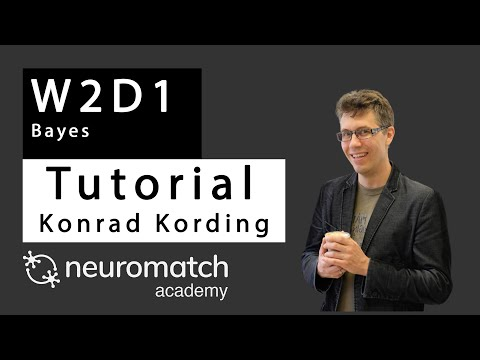

In [5]:
#@title Video 2: Bayes' theorem
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='ewQPHQMcdBs', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video



Bayes' rule tells us how to combine two sources of information: the prior (e.g., a noisy representation of our expectations about where the stimulus might come from) and the likelihood (e.g., a noisy representation of the stimulus position on a given trial), to obtain a posterior distribution taking into account both pieces of information. Bayes' rule states:

\begin{eqnarray}
\text{Posterior} = \frac{ \text{Likelihood} \times \text{Prior}}{ \text{Normalization constant}}
\end{eqnarray}

When both the prior and likelihood are Gaussians, this translates into the following form:

$$
\begin{array}{rcl}
\text{Likelihood} &=& \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \\
\text{Prior} &=& \mathcal{N}(\mu_{prior},\sigma_{prior}^2) \\
\text{Posterior} &\propto& \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \times \mathcal{N}(\mu_{prior},\sigma_{prior}^2) \\
&&= \mathcal{N}\left( \frac{\sigma^2_{likelihood}\mu_{prior}+\sigma^2_{prior}\mu_{likelihood}}{\sigma^2_{likelihood}+\sigma^2_{prior}}, \frac{\sigma^2_{likelihood}\sigma^2_{prior}}{\sigma^2_{likelihood}+\sigma^2_{prior}} \right) 
\end{array}
$$

In these equations, $\mathcal{N}(\mu,\sigma^2)$ denotes a Gaussian distribution with parameters $\mu$ and $\sigma^2$:
$$
\mathcal{N}(\mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \; \exp \bigg( \frac{-(x-\mu)^2}{2\sigma^2} \bigg)
$$

In Exercise 2A, we will use the first form of the posterior, where the two distributions are combined via pointwise multiplication.  Although this method requires more computation, it works for any type of probability distribution. In Exercise 2B, we will see that the closed-form solution shown on the line below produces the same result. 

## Exercise 2A: Finding the posterior computationally

Imagine an experiment where participants estimate the location of a noise-emitting object. To estimate its position, the participants can use two sources of information: 
  1. new noisy auditory information (the likelihood)
  2. prior visual expectations of where the stimulus is likely to come from (visual prior). 

The auditory and visual information are both noisy, so participants will combine these sources of information to better estimate the position of the object.

We will use Gaussian distributions to represent the auditory likelihood (in red), and a Gaussian visual prior (expectations - in blue). Using Bayes rule, you will combine them into a posterior distribution that summarizes the probability that the object is in each location. 

We have provided you with a ready-to-use plotting function, and a code skeleton.

* Use `my_gaussian`, the answer to exercise 1, to generate an auditory likelihood with parameters $\mu$ = 3 and $\sigma$ = 1.5
* Generate a visual prior with parameters $\mu$ = -1 and $\sigma$ = 1.5
* Calculate the posterior using pointwise multiplication of the likelihood and prior. Don't forget to normalize so the posterior adds up to 1. 
* Plot the likelihood, prior and posterior using the predefined function `posterior_plot`



In [6]:
def compute_posterior_pointwise(prior, likelihood):
  ##############################################################################
  # Write code to compute the posterior from the prior and likelihood via
  # pointwise multiplication. (You may assume both are defined over the same x-axis)
  #
  # Comment out the line below to test your solution
 # raise NotImplementedError("Finish the simulation code first")
  ##############################################################################

  posterior = prior * likelihood

  return posterior


def localization_simulation(mu_auditory=3.0, sigma_auditory=1.5,
                            mu_visual=-1.0, sigma_visual=1.5):

  ##############################################################################
  ## Using the x variable below,
  ##      create a gaussian called 'auditory' with mean 3, and std 1.5
  ##      create a gaussian called 'visual' with mean -1, and std 1.5
  #
  #
  ## Comment out the line below to test your solution
 # raise NotImplementedError("Finish the simulation code first")
  ###############################################################################
  x = np.arange(-8, 9, 0.1)

  auditory = my_gaussian(x, mu_auditory, sigma_auditory)
  visual = my_gaussian(x, mu_visual, sigma_visual)
  posterior = compute_posterior_pointwise(auditory, visual)

  return x, auditory, visual, posterior


# Uncomment the lines below to plot the results
# x, auditory, visual, posterior_pointwise = localization_simulation()
# posterior_plot(x, auditory, visual, posterior_pointwise)

## Interactive Demo: What affects the posterior?

Now that we can compute the posterior of two Gaussians with *Bayes rule*, let's vary the parameters of those Gaussians to see how changing the prior and likelihood affect the posterior. 

**Hit the Play button or Ctrl+Enter in the cell below** and play with the sliders to get an intuition for how the means and standard deviations of prior and likelihood influence the posterior.

When does the prior have the strongest influence over the posterior? When is it the weakest?  

In [7]:
#@title
#@markdown Make sure you execute this cell to enable the widget!

x = np.arange(-10, 11, 0.1)

import ipywidgets as widgets

def refresh(mu_auditory=3, sigma_auditory=1.5, mu_visual=-1, sigma_visual=1.5):
    auditory = my_gaussian(x, mu_auditory, sigma_auditory)
    visual = my_gaussian(x, mu_visual, sigma_visual)
    posterior_pointwise = visual * auditory
    posterior_pointwise /= posterior_pointwise.sum()

    w_auditory = (sigma_visual** 2) / (sigma_auditory**2 + sigma_visual**2)
    theoretical_prediction = mu_auditory * w_auditory + mu_visual * (1 - w_auditory)

    ax = posterior_plot(x, auditory, visual, posterior_pointwise)
    ax.plot([theoretical_prediction, theoretical_prediction],
            [0, posterior_pointwise.max() * 1.2], '-.', color='xkcd:medium gray')
    ax.set_title(f"Gray line shows analytical mean of posterior: {theoretical_prediction:0.2f}")
    plt.show()

style = {'description_width': 'initial'}

_ = widgets.interact(refresh,
    mu_auditory=widgets.FloatSlider(value=2, min=-10, max=10, step=0.5, description="mu_auditory:", style=style),
    sigma_auditory=widgets.FloatSlider(value=0.5, min=0.5, max=10, step=0.5, description="sigma_auditory:", style=style),
    mu_visual=widgets.FloatSlider(value=-2, min=-10, max=10, step=0.5, description="mu_visual:", style=style),
    sigma_visual=widgets.FloatSlider(value=0.5, min=0.5, max=10, step=0.5, description="sigma_visual:", style=style)
)

interactive(children=(FloatSlider(value=2.0, description='mu_auditory:', max=10.0, min=-10.0, step=0.5, style=…

## Video 3: Multiplying Gaussians

Video available at https://youtube.com/watch?v=AbXorOLBrws


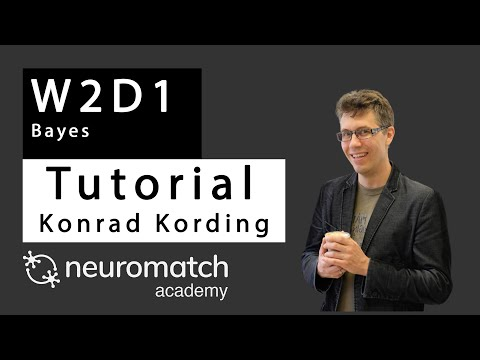

In [9]:
#@title
from IPython.display import YouTubeVideo

video = YouTubeVideo(id='AbXorOLBrws', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Exercise 2B: Finding the posterior analytically

[If you are running short on time, feel free to skip the coding exercise below].

As you may have noticed from the interactive demo, the product of two Gaussian distributions, like our prior and likelihood, remains a Gaussian, regardless of the parameters. We can directly compute the  parameters of that Gaussian from the means and variances of the prior and likelihood. For example, the posterior mean is given by:

$$ \mu_{posterior} = \frac{\mu_{auditory} \cdot \frac{1}{\sigma_{auditory}^2} + \mu_{visual} \cdot \frac{1}{\sigma_{visual}^2}}{1/\sigma_{auditory}^2 + 1/\sigma_{visual}^2} 
$$

This formula is a special case for two Gaussians, but is a very useful one because:
*   The posterior has the same form (here, a normal distribution) as the prior, and
*   There is simple, closed-form expression for its parameters.

When these properties hold, we call them **conjugate distributions** or **conjugate priors** (for a particular likelihood). Working with conjugate distributions is very convenient; otherwise, it is often necessary to use computationally-intensive numerical methods to combine the prior and likelihood. 

In this exercise, we ask you to verify that property.  To do so, we will hold our auditory likelihood constant as an $\mathcal{N}(3, 1.5)$ distribution, while considering visual priors with different means ranging from $\mu=-10$ to $\mu=10$. For each prior,

* Compute the posterior distribution using the function you wrote in Exercise 2A. Next, find its mean. The mean of a probability distribution is $\int_x p(x) dx$ or $\sum_x x\cdot p(x)$. 
* Compute the analytical posterior mean from auditory and visual using the equation above.
* Use the provided plotting code to plot both estimates of the mean. 

Are the estimates of the posterior mean the same in both cases? 

Using these results, try to predict the posterior mean for the combination of a $\mathcal{N}(-4,4)$ prior and and $\mathcal{N}(4, 2)$ likelihood. Use the widget above to check your prediction. You can enter values directly by clicking on the numbers to the right of each slider; $\sqrt{2} \approx 1.41$.

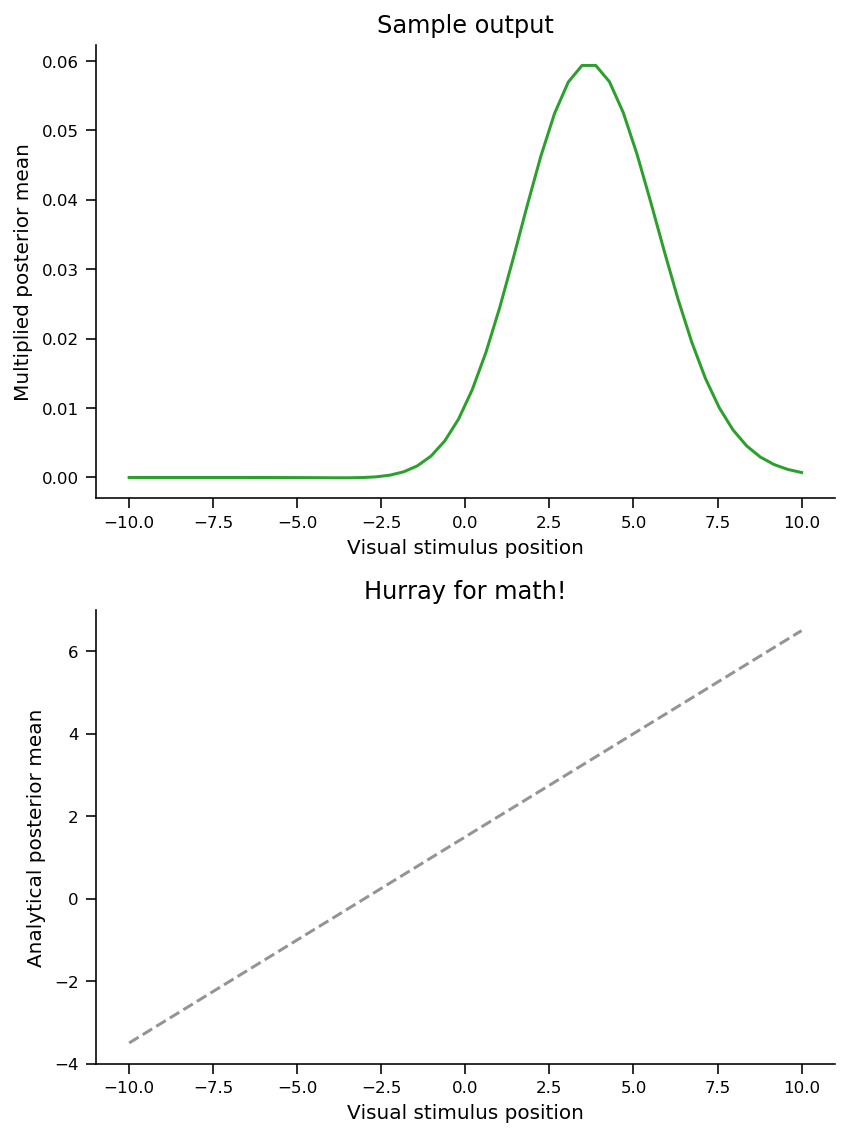

In [9]:
def compare_computational_analytical_means():
  x = np.arange(-10, 11, 0.1)

  # Fixed auditory likelihood
  mu_auditory = 3
  sigma_auditory = 1.5
  likelihood = my_gaussian(x, mu_auditory, sigma_auditory)

  # Varying visual prior
  mu_visuals = np.linspace(-10, 10)
  sigma_visual = 1.5

  # Accumulate results here
  mus_by_integration = []
  mus_analytical = []

  for mu_visual in mu_visuals:
    prior = my_gaussian(x, mu_visual, sigma_visual)
    posterior = compute_posterior_pointwise(prior, likelihood)

    ############################################################################
    ## Add code that will find the posterior mean via numerical integration
    #
    ############################################################################
    mu_integrated = np.sum(x*posterior)

    ############################################################################
    ## Add more code below that will calculate the posterior mean analytically
    #
    # Comment out the line below to test your solution
    # raise NotImplementedError("Please add code to find the mean both ways first")
    ############################################################################
    mu_analytical = ((mu_auditory / sigma_auditory ** 2 + mu_visual / sigma_visual ** 2) /
                  (1 / sigma_auditory ** 2 + 1 / sigma_visual ** 2))
    mus_by_integration.append(mu_integrated)
    mus_analytical.append(mu_analytical)

  return mu_visuals, mus_analytical, mus_by_integration


# Uncomment the lines below to visualize your results
mu_visuals, mu_analytical, mu_computational = compare_computational_analytical_means()
plot_visual(mu_visuals, mu_analytical, mu_computational)

In [10]:
mu_visuals, mu_analytical, mu_computational

(array([-10.        ,  -9.59183673,  -9.18367347,  -8.7755102 ,
         -8.36734694,  -7.95918367,  -7.55102041,  -7.14285714,
         -6.73469388,  -6.32653061,  -5.91836735,  -5.51020408,
         -5.10204082,  -4.69387755,  -4.28571429,  -3.87755102,
         -3.46938776,  -3.06122449,  -2.65306122,  -2.24489796,
         -1.83673469,  -1.42857143,  -1.02040816,  -0.6122449 ,
         -0.20408163,   0.20408163,   0.6122449 ,   1.02040816,
          1.42857143,   1.83673469,   2.24489796,   2.65306122,
          3.06122449,   3.46938776,   3.87755102,   4.28571429,
          4.69387755,   5.10204082,   5.51020408,   5.91836735,
          6.32653061,   6.73469388,   7.14285714,   7.55102041,
          7.95918367,   8.36734694,   8.7755102 ,   9.18367347,
          9.59183673,  10.        ]),
 [-3.500000000000001,
  -3.29591836734694,
  -3.091836734693878,
  -2.8877551020408165,
  -2.6836734693877555,
  -2.479591836734695,
  -2.275510204081633,
  -2.0714285714285716,
  -1.86734693877

# Section 3: Conclusion

This tutorial introduced the Gaussian distribution and used Bayes' Theorem to combine Gaussians representing priors and likelihoods. In the next tutorial, we will use these concepts to probe how subjects integrate sensory information.



Video available at https://youtube.com/watch?v=YC8GylOAAHs


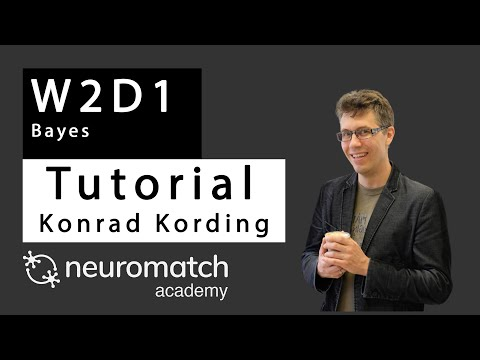

In [20]:
#@title Video 4: Conclusion
from IPython.display import YouTubeVideo

video = YouTubeVideo(id='YC8GylOAAHs', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Bonus Section: Multimodal Priors


**Only do this if the first half-hour has not yet passed.**

The preceeding exercises used a Gaussian prior, implying that participants expected the stimulus to come from a single location, though they might not know precisely where. However, suppose the subjects actually thought that sound might come from one of two distinct locations. Perhaps they can see two speakers (and know that speakers often emit noise). 

We could model this using a Gaussian prior with a large $\sigma$ that covers both locations, but that would also make every point in between seem likely too.A better approach is to adjust the form of the prior so that it better matches the participants' experiences/expectations. In this optional exercise, we will build a bimodal (2-peaked) prior out of Gaussians and examine the resulting posterior and its peaks. 

## Exercise 3: Implement and test a multimodal prior

* Complete the `bimodal_prior` function below to create a bimodal prior, comprised of the sum of two Gaussians with means $\mu = -3$ and $\mu = 3$. Use $\sigma=1$ for both Gaussians. Be sure to normalize the result so it is a proper probability distribution. 

* In Exercise 2, we used the mean location to summarize the posterior distribution. This is not always the best choice, especially for multimodal distributions. What is the mean of our new prior? Is it a particularly likely location for the stimulus? Instead, we will use the posterior **mode** to summarize the distribution. The mode is the *location* of the most probable part of the distribution. Complete `posterior_mode` below, to find it. (Hint: `np.argmax` returns the *index* of the largest element in an array).

* Run the provided simulation and plotting code. Observe what happens to the posterior as the likelihood gets closer to the different peaks of the prior.
* Notice what happens to the posterior when the likelihood is exactly in between the two modes of the prior (i.e., $\mu_{Likelihood} = 0$)

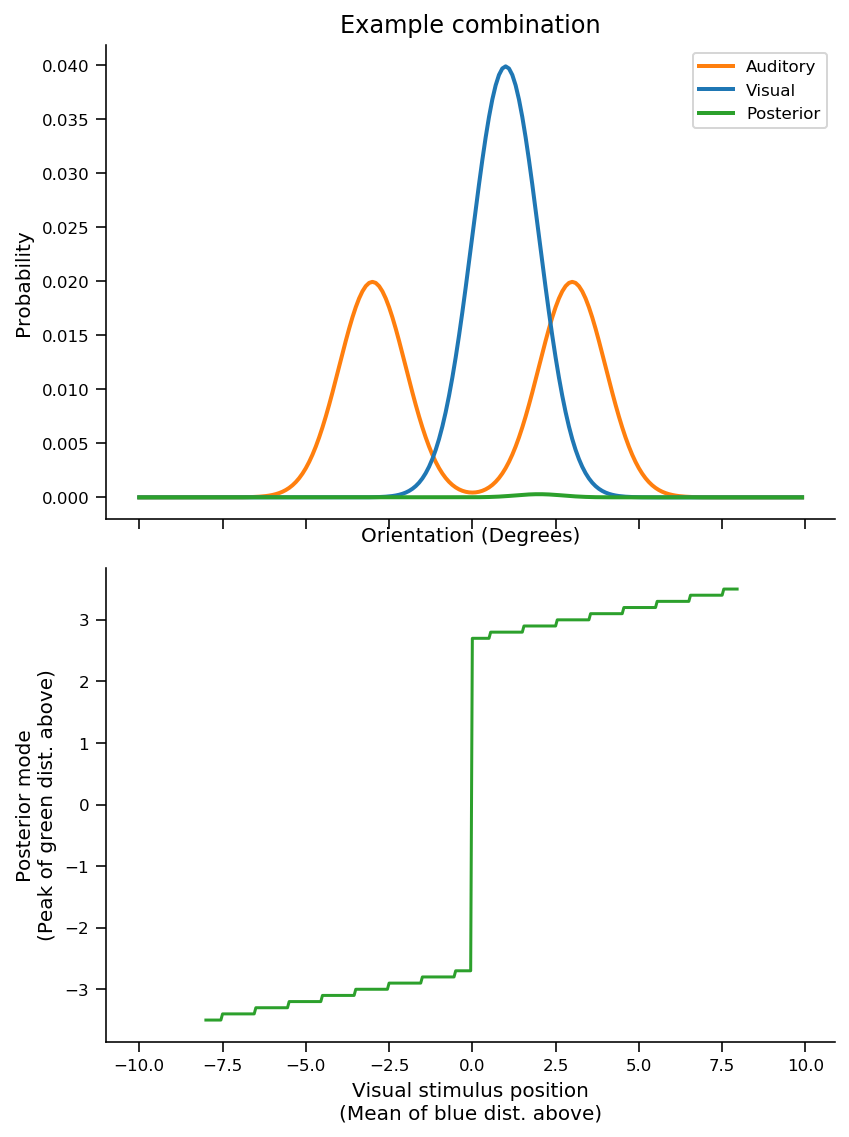

In [12]:
def bimodal_prior(x, mu_1=-3, sigma_1=1, mu_2=3, sigma_2=1):
  ################################################################################
  ## Finish this function so that it returns a bimodal prior, comprised of the
  # sum of two Gaussians
  #
  # Comment out the line below to test out your solution
  #raise NotImplementedError("Please implement the bimodal prior")
  ################################################################################
  prior = my_gaussian(x, mu_1, sigma_1) + my_gaussian(x, mu_2, sigma_2)
  prior /= prior.sum()

  return prior


def posterior_mode(x, posterior):
  ################################################################################
  ## Finish this function so that it returns the location of the mode
  #
  # Comment out the line below to test out your solution
 # raise NotImplementedError("Please implement the posterior mode")
  ################################################################################
  mode = x[np.argmax(posterior)]

  return mode


def multimodal_simulation(x, mus_visual, sigma_visual=1):
  """
  Simulate an experiment where bimodal prior is held constant while
  a Gaussian visual likelihood is shifted across locations.
  Args:
        x:            array of points at which prior/likelihood/posterior are evaluated
        mus_visual:   array of means for the Gaussian likelihood
        sigma_visual: scalar standard deviation for the Gaussian likelihood

  Returns:
    posterior_modes:  array containing the posterior mode for each mean in mus_visual
  """

  prior = bimodal_prior(x, -3, 1, 3, 1)
  posterior_modes = []

  for mu in mus_visual:
    likelihood = my_gaussian(x, mu, 3)
    posterior = compute_posterior_pointwise(prior, likelihood)

    p_mode = posterior_mode(x, posterior)
    posterior_modes.append(p_mode)

  return posterior_modes


x = np.arange(-10, 10, 0.1)
mus = np.arange(-8, 8, 0.05)
# Uncomment the lines below to visualize your results
posterior_modes = multimodal_simulation(x, mus, 1)
multimodal_plot(x,
                 bimodal_prior(x, -3, 1, 3, 1),
                 my_gaussian(x, 1, 1),
                 mus, posterior_modes)

# Causal inference with mixture of Gaussians

__Content creators:__ Vincent Valton, Konrad Kording, with help from Matt Krause

__Content reviewers:__ Matt Krause, Jesse Livezey, Karolina Stosio, Saeed Salehi, Michael Waskom

# Tutorial Objectives

The previous notebook introduced Gaussians and Bayes' rule, allowing us to model very simple combinations of auditory and visual input. In this and the following notebook, we will use those building blocks to explore more complicated sensory integration and ventriloquism! 

In this notebook, you will:
1. Learn more about the problem setting, which we wil also use in Tutorial 3,
2. Implement a mixture-of-Gaussian prior, and
3. Explore how that prior produces more complex posteriors.

Video available at https://youtube.com/watch?v=2e0P8TL1PtI


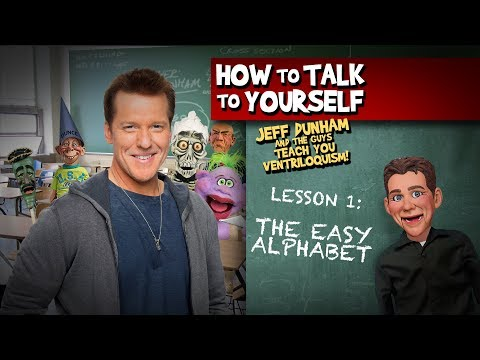

In [20]:
#@title Video 2: Mixture-of-Gaussians and Bayes' Theorem
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='2e0P8TL1PtI', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Video available at https://youtube.com/watch?v=GdIwJWsW9-s


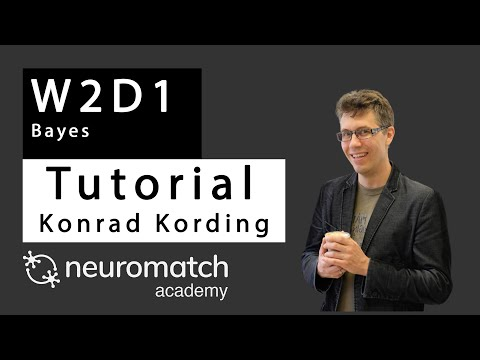

In [1]:
# @title Video 1: Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='GdIwJWsW9-s', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
## Setup  
Please execute the cells below to initialize the notebook environment.

In [13]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [16]:
#@title Figure Settings
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
#@title Helper functions

def my_gaussian(x_points, mu, sigma):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Returns normalized Gaussian estimated at points `x_points`, with parameters `mu` and `sigma`

    Args:
      x_points (numpy array of floats) - points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - standard deviation of the gaussian
    Returns:
      (numpy array of floats): normalized Gaussian (i.e. without constant) evaluated at `x`
    """
    px = np.exp(- 1/2/sigma**2 * (mu - x_points) ** 2)

    px = px / px.sum() # this is the normalization part with a very strong assumption, that
                       # x_points cover the big portion of probability mass around the mean.
                       # Please think/discuss when this would be a dangerous assumption.

    return px

def plot_mixture_prior(x, gaussian1, gaussian2, combined):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Plots a prior made of a mixture of gaussians

    Args:
      x (numpy array of floats):         points at which the likelihood has been evaluated
      gaussian1 (numpy array of floats): normalized probabilities for Gaussian 1 evaluated at each `x`
      gaussian2 (numpy array of floats): normalized probabilities for Gaussian 2 evaluated at each `x`
      posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`

    Returns:
      Nothing
    """
    fig, ax = plt.subplots()
    ax.plot(x, gaussian1, '--b', LineWidth=2, label='Gaussian 1')
    ax.plot(x, gaussian2, '-.b', LineWidth=2, label='Gaussian 2')
    ax.plot(x, combined, '-r', LineWidth=2, label='Gaussian Mixture')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')


# Section 1: Motivating example

Ventriloquists produce the illusion that their puppets are talking because:
1. We observe the visual input of the puppet moving its mouth, as if speaking.
2. The speech that the puppeteer generates originates near the puppet's mouth. 

Since we are accustomed to voices coming from moving mouths, we tend to interpret the voice as coming directly from the puppet itself rather than from the puppeteer (who is also hiding his/her own mouth movements). In the remaining tutorials, we will study how this illusion breaks down as the distance between the visual stimulus (the puppet's mouth) and the auditory stimulus (the puppeter's concealed speech) changes. 

Imagine an experiment where participants are shown a puppet moving its mouth at a location directly in front of them (at position 0˚). The subjects are told that 75% of the time, the voice they hear originates from the puppet. On the remaining 25% of trials, sounds come from elsewhere. Participants learn this over multiple trials, after which a curtain is dropped in front of the puppeteer and the puppet. 

Next, we present only the auditory stimulus at varying locations and we ask participants to report where the source of the sound is located. The participants have access to two pieces of information:

*   The prior information about sound localization, learned during the trials before the curtain fell.
*   Their noisy sensory estimates about where a particular sound originates. 

Our eventual goal, which we achieve in Tutorial 3, is to predict the subjects' responses: when do subjects ascribe a sound to the puppet, and when do they believe it originated elsewhere? Doing so requires building a prior that captures the participant's knowledge and expectations, which we wil do in the exercises that follow here. 

# Section 2: Mixture-of-Gaussians Prior

In the previous tutorial, you learned how to create a single Gaussian prior that could represent one of these possibilties. A broad Gaussian with a large $\sigma$ could represent sounds originating from nearly anywhere, while a narrow Gaussian with $\mu$ near zero could represent sounds orginating from the puppet. 

Here, we will combine those into a mixure-of-Gaussians probability density function (PDF) that captures both possibilties. We will control how the Gaussians are mixed by summing them together with a 'mixing' or weight parameter $p_{common}$, set to a value between 0 and 1, like so:

\begin{eqnarray}
    \text{Mixture} = \bigl[\; p_{common} \times \mathcal{N}(\mu_{common},\sigma_{common}) \; \bigr] + \bigl[ \;\underbrace{(1-p_{common})}_{p_{independent}} \times \mathcal{N}(\mu_{independent},\sigma_{independent}) \; \bigr]
\end{eqnarray}

$p_{common}$ denotes the probability that auditory stimulus shares a "common" source with the learnt visual input; in other words, the probability that the "puppet" is speaking. You might think that we need to include a separate weight for the possibility that sound is "independent" from the puppet. nHowever, since there are only two, mutually-exclusive possibilties, we can replace $p_{independent}$ with $(1 - p_{common})$ since, by the law of total probability, $p_{common} + p_{independent}$ must equal one. 

Using the formula above, complete the code to build this mixture-of-Gaussians PDF: 
* Generate a Gaussian with mean 0 and standard deviation 0.5 to be the 'common' part of the Gaussian mixture prior. (This is already done for you below).
* Generate another Gaussian with mean 0 and standard deviation 3 to serve as the 'independent' part. 
* Combine the two Gaussians to make a new prior by mixing the two Gaussians with mixing parameter $p_{common}$ = 0.75 so that the peakier "common-cause" Gaussian has 75% of the weight. Don't forget to normalize afterwards! 

Hints:
* Code for the `my_gaussian` function from Tutorial 1 is available for you to use. Its documentation is below. 


**Helper function(s)**


In [13]:
help(my_gaussian)

Help on function my_gaussian in module __main__:

my_gaussian(x_points, mu, sigma)
    DO NOT EDIT THIS FUNCTION !!!
    
    Returns normalized Gaussian estimated at points `x_points`, with parameters `mu` and `sigma`
    
    Args:
      x_points (numpy array of floats) - points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - standard deviation of the gaussian
    Returns:
      (numpy array of floats): normalized Gaussian (i.e. without constant) evaluated at `x`



## Exercise 1: Implement the prior 

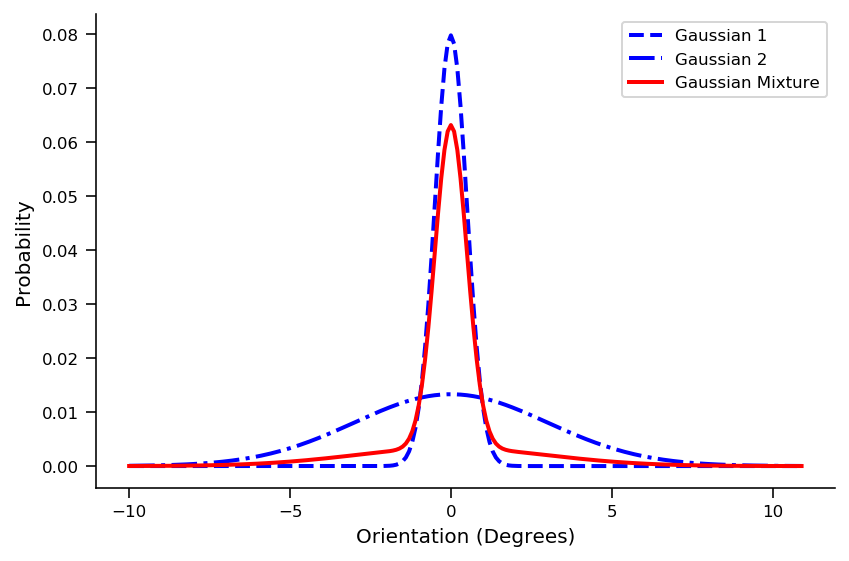

In [18]:
def mixture_prior(x, mean=0, sigma_common=0.5, sigma_independent=3, p_common=0.75):

  ###############################################################################
  ## Insert your code here to:
  #   * Create a second gaussian representing the independent-cause component
  #   * Combine the two priors, using the mixing weight p_common. Don't forget
  #      to normalize the result so it remains a proper probability density function
  #
  #   * Comment the line below to test out your function
  #raise NotImplementedError("Please complete Exercise 1")
  ###############################################################################

  gaussian_common = my_gaussian(x, mean, sigma_common)
  gaussian_independent = my_gaussian(x, mean, sigma_independent)
  mixture = p_common * gaussian_common + ((1-p_common) * gaussian_independent)
  mixture = mixture / np.sum(mixture)

  return gaussian_common, gaussian_independent, mixture


x = np.arange(-10, 11, 0.1)

# Uncomment the lines below to visualize out your solution
common, independent, mixture = mixture_prior(x)
plot_mixture_prior(x, common, independent, mixture)


# Section 3: Bayes Theorem with Complex Posteriors

Video available at https://youtube.com/watch?v=LWKM35te0WI


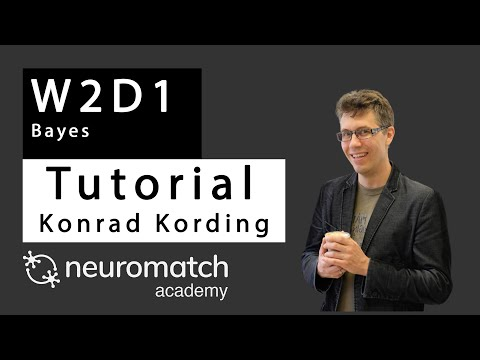

In [15]:
#@title Video 2: Mixture-of-Gaussians and Bayes' Theorem
video = YouTubeVideo(id='LWKM35te0WI', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Now that we have created a mixture of Gaussians prior that embodies the participants' expectations about sound location, we want to compute the posterior probability, which represents the subjects' beliefs about a specific sound's origin. 

To do so we will compute the posterior by using *Bayes Theorem* to combine the mixture-of-gaussians prior and varying auditory Gaussian likelihood. This works exactly the same as in Tutorial 1: we simply multiply the prior and likelihood pointwise, then normalize the resulting distribution so it sums to 1. (The closed-form solution from Exercise 2B, however, no longer applies to this more complicated prior). 

Here, we provide you with the code mentioned in the video (lucky!). Instead, use the interactive demo to explore how a mixture-of-Gaussians prior and Gaussian likelihood interact. For simplicity, we have fixed the prior mean to be zero. We also recommend starting with same other prior parameters used in Exercise 1: $\sigma_{common} = 0.5, \sigma_{independent} = 3, p_{common}=0.75$; vary the likelihood instead. 

Unlike the demo in Tutorial 1, you should see several qualitatively different effects on the posterior, depending on the relative position and width of likelihood. Pay special attention to both the overall shape of the posterior and the location of the peak. What do you see?

## Interactive Demo 1: Mixture-of-Gaussian prior and the posterior

In [19]:
#@title
#@markdown Make sure you execute this cell to enable the widget!

fig_domain = np.arange(-10, 11, 0.1)
import ipywidgets as widgets

def refresh(sigma_common=0.5, sigma_independent=3, p_common=0.75, mu_auditory=3, sigma_auditory=1.5):
    _, _, prior = mixture_prior(fig_domain, 0, sigma_common, sigma_independent, p_common)
    likelihood = my_gaussian(fig_domain, mu_auditory, sigma_auditory)

    posterior = prior * likelihood
    posterior /= posterior.sum()

    plt.plot(fig_domain, prior, label="Mixture Prior")
    plt.plot(fig_domain, likelihood, label="Likelihood")
    plt.plot(fig_domain, posterior, label="Posterior")

    plt.legend()

    plt.show()

style = {'description_width': 'initial'}

_ = widgets.interact(refresh,
    sigma_common=widgets.FloatSlider(value=0.5, min=0.01, max=10, step=0.5, description="sigma_common", style=style),
    sigma_independent=widgets.FloatSlider(value=3, min=0.01, max=10, step=0.5, description="sigma_independent:", style=style),
    p_common=widgets.FloatSlider(value=0.75, min=0, max=1, steps=0.01, description="p_common"),
    mu_auditory=widgets.FloatSlider(value=2, min=-10, max=10, step=0.1, description="mu_auditory:", style=style),
    sigma_auditory=widgets.FloatSlider(value=0.5, min=0.01, max=10, step=0.5, description="sigma_auditory:", style=style),
)

interactive(children=(FloatSlider(value=0.5, description='sigma_common', max=10.0, min=0.01, step=0.5, style=S…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/NMA2020/tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial2_Solution_4d414185.py)



# Section 3: Conclusion

In [ ]:
#@title Video 3: Outro
video = YouTubeVideo(id='UgeAtE8xZT8', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Bayesian Decision Theory & Cost functions
__Content creators:__ Vincent Valton, Konrad Kording, with help from Matthew Krause

__Content reviewers:__ Matthew Krause, Jesse Livezey, Karolina Stosio, Saeed Salehi

# Tutorial Objectives

*This tutorial is optional! Please do not feel pressured to finish it!*

In the previous tutorials, we investigated the posterior, which describes  beliefs based on a combination of current evidence and prior experience. This tutorial focuses on Bayesian Decision Theory, which combines the posterior with **cost functions** that allow us to quantify the potential impact of making a decision or choosing an action based on that posterior. Cost functions are therefore critical for turning probabilities into actions!

In Tutorial 3, we used the mean of the posterior $p(x | \tilde x)$ as a proxy for the response $\hat x$ for the participants. What prompted us to use the mean of the posterior as a **decision rule**? In this tutorial we will see how different common decision rules such as the choosing the mean, median or mode of the posterior distribution correspond to minimizing different cost functions.

In this tutorial, you will
  1. Implement three commonly-used cost functions: mean-squared error, absolute error, and zero-one loss
  2. Discover the concept of expected loss, and
  3. Choose optimal locations on the posterior that minimize these cost functions. You will verify that it these locations can be found analytically as well as empirically.

Video available at https://youtube.com/watch?v=z2DF4H_sa-k


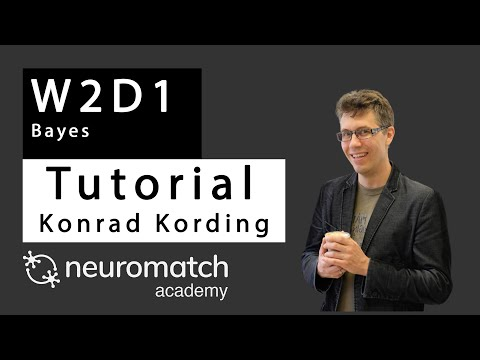

In [6]:
#@title Video 1: Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='z2DF4H_sa-k', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
Please execute the cell below to initialize the notebook environment


--- 
### Setup

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#@title Figure Settings
import ipywidgets as widgets
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
# @title Helper Functions

def my_gaussian(x_points, mu, sigma):
  """Returns un-normalized Gaussian estimated at points `x_points`

  DO NOT EDIT THIS FUNCTION !!!

  Args :
    x_points (numpy array of floats) - points at which the gaussian is evaluated
    mu (scalar) - mean of the Gaussian
    sigma (scalar) - std of the gaussian

  Returns:
    (numpy array of floats): un-normalized Gaussian (i.e. without constant) evaluated at `x`
  """
  return np.exp(-(x_points-mu)**2/(2*sigma**2))

def visualize_loss_functions(mse=None, abse=None, zero_one=None):
  """Visualize loss functions
    Args:
      - mse (func) that returns mean-squared error
      - abse: (func) that returns absolute_error
      - zero_one: (func) that returns zero-one loss
    All functions should be of the form f(x, x_hats). See Exercise #1.

    Returns:
      None
    """

  x = np.arange(-3, 3.25, 0.25)

  fig, ax = plt.subplots(1)

  if mse is not None:
    ax.plot(x, mse(0, x), linewidth=2, label="Mean Squared Error")
  if abse is not None:
    ax.plot(x, abse(0, x), linewidth=2, label="Absolute Error")
  if zero_one_loss is not None:
    ax.plot(x, zero_one_loss(0, x), linewidth=2, label="Zero-One Loss")

  ax.set_ylabel('Cost')
  ax.set_xlabel('Predicted Value ($\hat{x}$)')
  ax.set_title("Loss when the true value $x$=0")
  ax.legend()
  plt.show()

def moments_myfunc(x_points, function):
    """Returns the mean, median and mode of an arbitrary function

    DO NOT EDIT THIS FUNCTION !!!

    Args :
      x_points (numpy array of floats) - x-axis values
      function (numpy array of floats) - y-axis values of the function evaluated at `x_points`

    Returns:
       (tuple of 3 scalars): mean, median, mode
    """

    # Calc mode of an arbitrary function
    mode = x_points[np.argmax(function)]

    # Calc mean of an arbitrary function
    mean = np.sum(x_points * function)

    # Calc median of an arbitrary function
    cdf_function = np.zeros_like(x_points)
    accumulator = 0
    for i in np.arange(x.shape[0]):
        accumulator = accumulator + posterior[i]
        cdf_function[i] = accumulator
    idx = np.argmin(np.abs(cdf_function - 0.5))
    median = x_points[idx]

    return mean, median, mode

def loss_plot(x, loss, min_loss, loss_label, show=False, ax=None):
  if not ax:
    fig, ax = plt.subplots()

  ax.plot(x, loss, '-C1', linewidth=2, label=loss_label)
  ax.axvline(min_loss, ls='dashed', color='C1', label='Minimum')
  ax.set_ylabel('Expected Loss')
  ax.set_xlabel('Orientation (Degrees)')
  ax.legend()

  if show:
    plt.show()

def loss_plot_subfigures(x,
              MSEloss, min_MSEloss, loss_MSElabel,
              ABSEloss, min_ABSEloss, loss_ABSElabel,
              ZeroOneloss, min_01loss, loss_01label):

  fig_w, fig_h = plt.rcParams.get('figure.figsize')
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(fig_w*2, fig_h*2), sharex=True)

  ax[0, 0].plot(x, MSEloss, '-C1', linewidth=2, label=loss_MSElabel)
  ax[0, 0].axvline(min_MSEloss, ls='dashed', color='C1', label='Minimum')
  ax[0, 0].set_ylabel('Expected Loss')
  ax[0, 0].set_xlabel('Orientation (Degrees)')
  ax[0, 0].set_title("Mean Squared Error")
  ax[0, 0].legend()

  pmoments_plot(x, posterior, ax=ax[1,0])

  ax[0, 1].plot(x, ABSEloss, '-C0', linewidth=2, label=loss_ABSElabel)
  ax[0, 1].axvline(min_ABSEloss, ls='dashdot', color='C0', label='Minimum')
  ax[0, 1].set_ylabel('Expected Loss')
  ax[0, 1].set_xlabel('Orientation (Degrees)')
  ax[0, 1].set_title("Absolute Error")
  ax[0, 1].legend()

  pmoments_plot(x, posterior, ax=ax[1,1])


  ax[0, 2].plot(x, ZeroOneloss, '-C2', linewidth=2, label=loss_01label)
  ax[0, 2].axvline(min_01loss, ls='dotted', color='C2', label='Minimum')
  ax[0, 2].set_ylabel('Expected Loss')
  ax[0, 2].set_xlabel('Orientation (Degrees)')
  ax[0, 2].set_title("0-1 Loss")
  ax[0, 2].legend()

  pmoments_plot(x, posterior, ax=ax[1,2])

  plt.show()

def pmoments_plot(x, posterior,
                  prior=None, likelihood=None, show=False, ax=None):

  if not ax:
    fig, ax = plt.subplots()


  if prior:
    ax.plot(x, prior, '-C1', linewidth=2, label='Prior')
  if likelihood:
    ax.plot(x, likelihood, '-C0', linewidth=2, label='Likelihood')
  ax.plot(x, posterior, '-C2', linewidth=4, label='Posterior')

  mean, median, mode = moments_myfunc(x, posterior)

  ax.axvline(mean, ls='dashed', color='C1', label='Mean')
  ax.axvline(median, ls='dashdot', color='C0', label='Median')
  ax.axvline(mode, ls='dotted', color='C2', label='Mode')
  ax.set_ylabel('Probability')
  ax.set_xlabel('Orientation (Degrees)')
  ax.legend()

  if show:
    plt.show()



def generate_example_pdfs():
  """Generate example probability distributions as in T2"""
  x=np.arange(-5, 5, 0.01)

  prior_mean = 0
  prior_sigma1 = .5
  prior_sigma2 = 3
  prior1 = my_gaussian(x, prior_mean, prior_sigma1)
  prior2 = my_gaussian(x, prior_mean, prior_sigma2)

  alpha = 0.05
  prior_combined = (1-alpha) * prior1 + (alpha * prior2)
  prior_combined = prior_combined / np.sum(prior_combined)

  likelihood_mean = -2.7
  likelihood_sigma = 1
  likelihood = my_gaussian(x, likelihood_mean, likelihood_sigma)
  likelihood = likelihood / np.sum(likelihood)

  posterior = prior_combined * likelihood
  posterior = posterior / np.sum(posterior)

  return x, prior_combined, likelihood, posterior

def plot_posterior_components(x, prior, likelihood, posterior):
  with plt.xkcd():
    fig = plt.figure()
    plt.plot(x, prior, '-C1', linewidth=2, label='Prior')
    plt.plot(x, likelihood, '-C0', linewidth=2, label='Likelihood')
    plt.plot(x, posterior, '-C2', linewidth=4, label='Posterior')
    plt.legend()
    plt.title('Sample Output')
    plt.show()

### The Posterior Distribution

This notebook will use a model similar to the puppet & puppeteer sound experiment developed in Tutorial 2, but with different probabilities for $p_{common}$, $p_{independent}$, $\sigma_{common}$ and $\sigma_{independent}$. Specifically, our model will consist of these components, combined according to Bayes' rule:
$$
\begin{eqnarray}
\textrm{Prior} &=& \begin{cases} \mathcal{N_{common}}(0, 0.5) & 95\% \textrm{ weight}\\
                                 \mathcal{N_{independent}}(0, 3.0) &  5\% \textrm{ weight} \\
                    \end{cases}\\\\
\textrm{Likelihood} &= &\mathcal{N}(-2.7, 1.0)
\end{eqnarray}
$$

We will use this posterior as an an example through this notebook. Please run the cell below to import and plot the model. You do not need to edit anything. These parameter values were deliberately chosen for illustration purposes: there is nothing intrinsically special about them, but they make several of the exercises easier. 



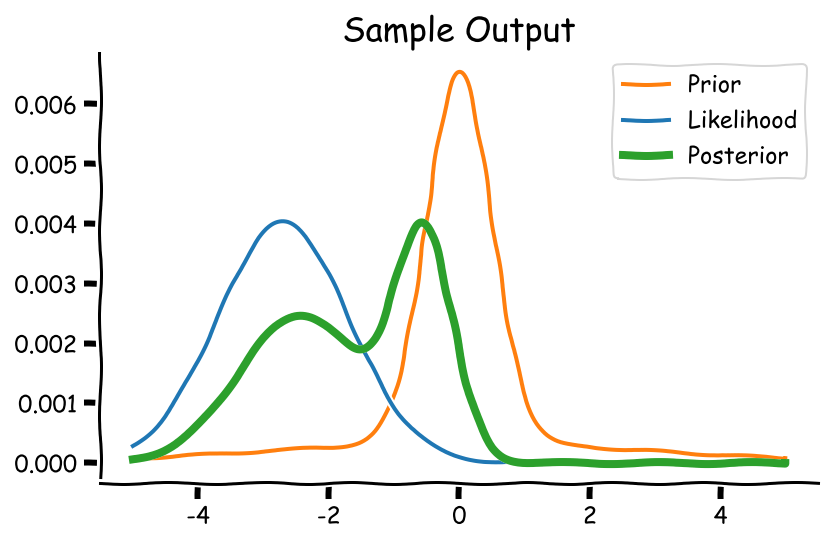

In [8]:
x, prior, likelihood, posterior = generate_example_pdfs()
plot_posterior_components(x, prior, likelihood, posterior)

# Section 1: The Cost Functions

Next, we will implement the cost functions. 
A cost function determines the "cost" (or penalty) of estimating $\hat{x}$ when the true or correct quantity is really $x$ (this is essentially the cost of the error between the true stimulus value: $x$ and our estimate: $\hat x$ -- Note that the error can be defined in different ways):

$$\begin{eqnarray}
\textrm{Mean Squared Error} &=& (x - \hat{x})^2 \\ 
\textrm{Absolute Error} &=& \big|x - \hat{x}\big| \\ 
\textrm{Zero-One Loss} &=& \begin{cases}
                            0,& \text{if } x = \hat{x} \\
                            1,              & \text{otherwise}
                            \end{cases}
\end{eqnarray}
$$

In the cell below, fill in the body of these cost function. Each function should take one single value for $x$ (the true stimulus value : $x$) and one or more possible value estimates: $\hat{x}$. 

Return an array containing the costs associated with predicting $\hat{x}$ when the true value is $x$. Once you have written all three functions, uncomment the final line to visulize your results.

 _Hint:_ These functions are easy to write (1 line each!) but be sure *all* three functions return arrays of `np.float` rather than another data type.

## Exercise 1: Implement the cost functions

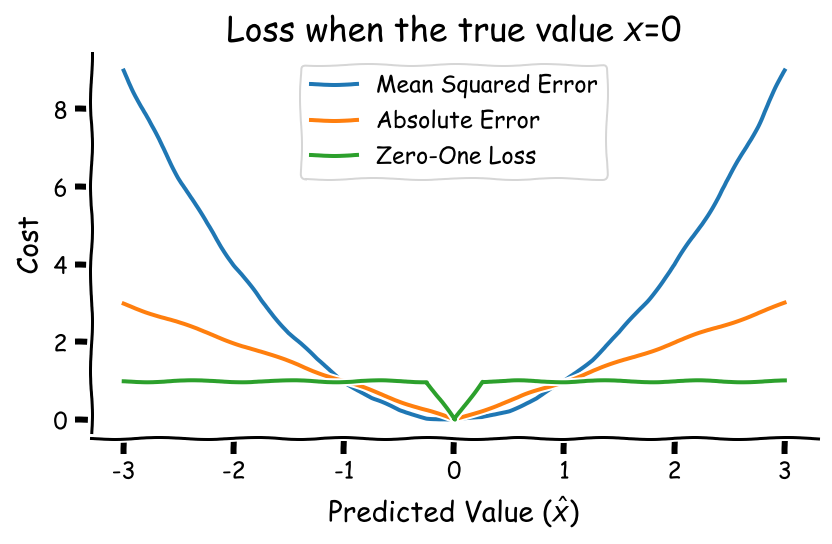

In [9]:
def mse(x, x_hats):
  """Mean-squared error cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x
    Returns:
      same shape/type as x_hats): MSE costs associated with
      predicting x_hats instead of x$
  """

  ##############################################################################
  # Complete the MSE cost function
  #
  ### Comment out the line below to test your function
  #raise NotImplementedError("You need to complete the MSE cost function!")
  ##############################################################################

  my_mse = (x - x_hats)**2
  return my_mse


def abs_err(x, x_hats):
  """Absolute error cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x
    Returns:
      (same shape/type as x_hats): absolute error costs associated with
      predicting x_hats instead of x$
  """

  ##############################################################################
  # Complete the absolute error cost function
  #
  ### Comment out the line below to test your function
  #raise NotImplementedError("You need to complete the absolute error function!")
  ##############################################################################

  my_abs_err = np.abs(x - x_hats)
  return my_abs_err


def zero_one_loss(x, x_hats):
  """Zero-One loss cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x
    Returns:
      (same shape/type as x_hats) of the 0-1 Loss costs associated with predicting x_hat instead of x
  """

  ##############################################################################
  # Complete the zero-one loss cost function
  #
  ### Comment out the line below to test your function
  #raise NotImplementedError("You need to complete the 0-1 loss cost function!")
  ##############################################################################

  my_zero_one_loss = (x != x_hats).astype(np.float)
  return my_zero_one_loss


## When you are done with the functions above, uncomment the line below to
## visualize them
with plt.xkcd():
  visualize_loss_functions(mse, abs_err, zero_one_loss)


# Section 2: Expected Loss
    


Video available at https://youtube.com/watch?v=FTBpCfylV_Y


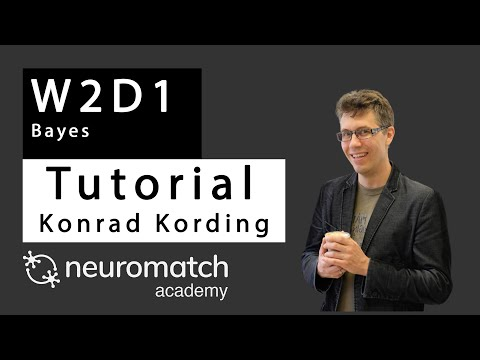

In [10]:
#@title Video 2: Expected Loss
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='FTBpCfylV_Y', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

A posterior distribution tells us about the confidence or credibility we assign to different choices. A cost function describes the penalty we incur when choosing an incorrect option. These concepts can be combined into an *expected loss* function. Expected loss is defined as:

$$
\begin{eqnarray}
    \mathbb{E}[\text{Loss} | \hat{x}] = \int L[\hat{x},x] \odot  p(x|\tilde{x}) dx
\end{eqnarray}
$$

where $L[ \hat{x}, x]$ is the loss function, $p(x|\tilde{x})$ is the posterior, and $\odot$ represents the [Hadamard Product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) (i.e., elementwise multiplication), and $\mathbb{E}[\text{Loss} | \hat{x}]$ is the expected loss. 

In this exercise, we will calculate the expected loss for the: means-squared error, the absolute error, and the zero-one loss over our bimodal posterior $p(x | \tilde x)$. 

**Suggestions:**
* We already pre-completed the code (commented-out) to calculate the mean-squared error, absolute error, and zero-one loss between $x$ and an estimate $\hat x$ using the functions you created in exercise 1
* Calculate the expected loss ($\mathbb{E}[MSE Loss]$) using your posterior (imported above as `posterior`) & each of the loss functions described above (MSELoss, ABSELoss, and Zero-oneLoss).
* Find the x position that minimizes the expected loss for each cost function and plot them using the `loss_plot` function provided (commented-out)

## Exercise 2: Finding the expected loss empirically via integration


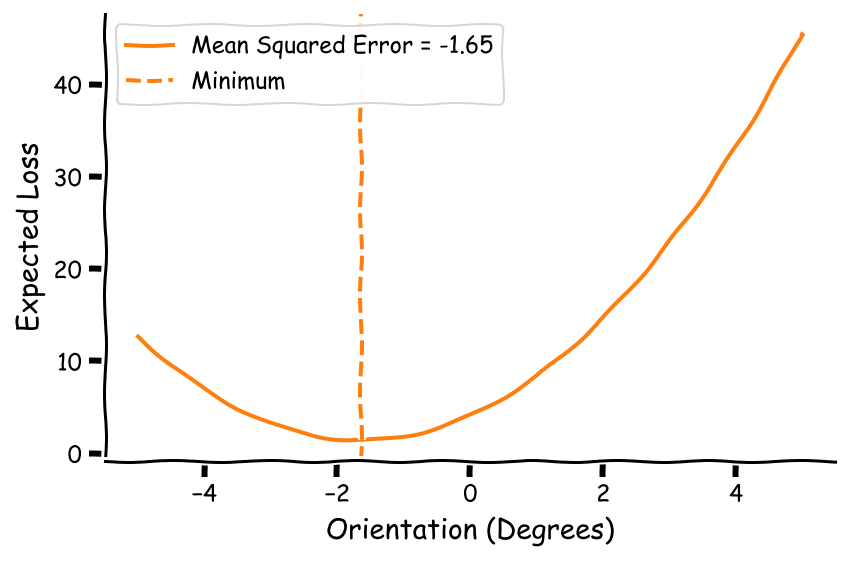

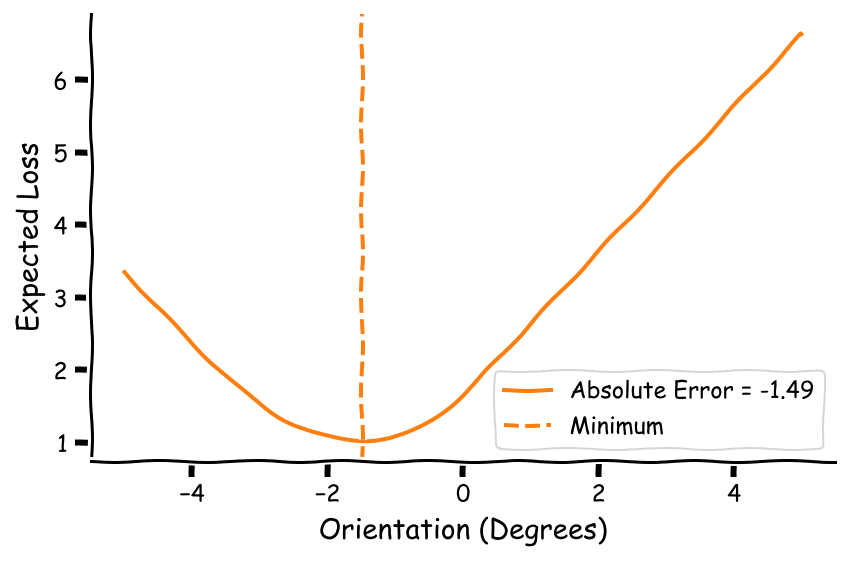

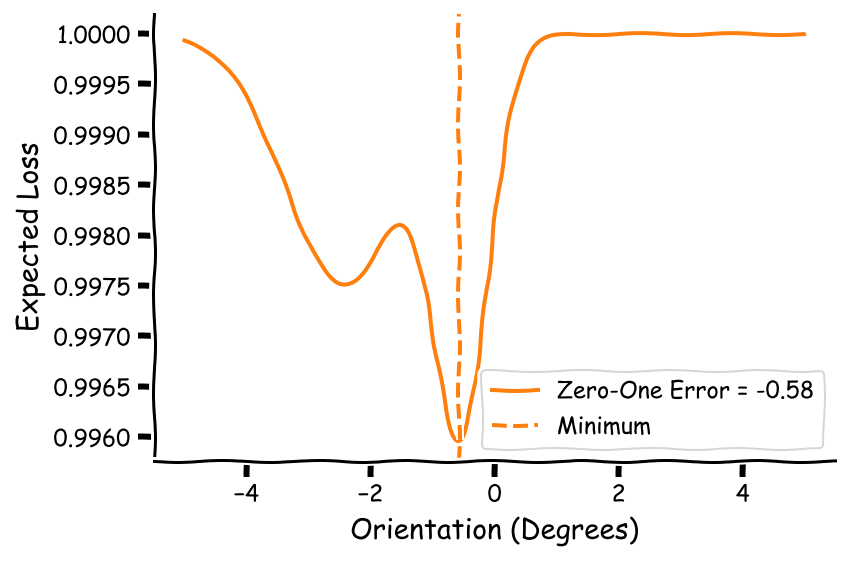

In [11]:
def expected_loss_calculation(x, posterior):

  ExpectedLoss_MSE = np.zeros_like(x)
  ExpectedLoss_ABSE = np.zeros_like(x)
  ExpectedLoss_01 = np.zeros_like(x)

  for idx in np.arange(x.shape[0]):
    estimate = x[idx]

    ###################################################################
    ## Insert code below to find the expected loss under each loss function
    ##
    ## remove the raise when the function is complete
    #raise NotImplementedError("Calculate the expected loss over all x values!")
    ###################################################################

    MSELoss = mse(estimate, x)
    ExpectedLoss_MSE[idx] = np.sum(MSELoss * posterior)

    ABSELoss = abs_err(estimate, x)
    ExpectedLoss_ABSE[idx] = np.sum(ABSELoss * posterior)

    ZeroOneLoss = zero_one_loss(estimate, x)
    ExpectedLoss_01[idx] = np.sum(ZeroOneLoss * posterior)

  ###################################################################
  ## Now, find the `x` location that minimizes expected loss
  ##
  ## remove the raise when the function is complete
  # raise NotImplementedError("Finish the Expected Loss calculation")
  ###################################################################

  min_MSE = x[np.argmin(ExpectedLoss_MSE)]
  min_ABSE = x[np.argmin(ExpectedLoss_ABSE)]
  min_01 = x[np.argmin(ExpectedLoss_01)]

  return (ExpectedLoss_MSE, ExpectedLoss_ABSE, ExpectedLoss_01,
          min_MSE, min_ABSE, min_01)

## Uncomment the lines below to plot the expected loss as a function of the estimates
ExpectedLoss_MSE, ExpectedLoss_ABSE, ExpectedLoss_01,  min_MSE, min_ABSE, min_01 = expected_loss_calculation(x, posterior)

with plt.xkcd():
  loss_plot(x, ExpectedLoss_MSE, min_MSE, f"Mean Squared Error = {min_MSE:.2f}")
  loss_plot(x, ExpectedLoss_ABSE, min_ABSE, f"Absolute Error = {min_ABSE:.2f}")
  loss_plot(x, ExpectedLoss_01, min_01, f"Zero-One Error = {min_01:.2f}")

# Section 3: Analytical Solutions
    

Video available at https://youtube.com/watch?v=wmDD51N9rs0


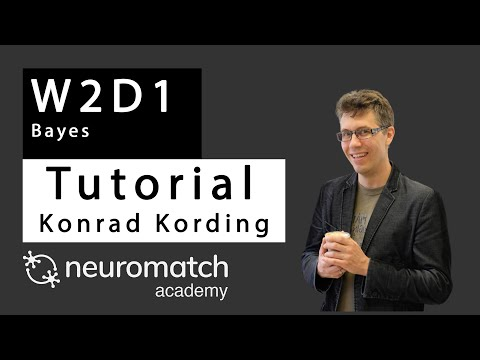

In [13]:
#@title Video 3: Analytical Solutions
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='wmDD51N9rs0', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

In the previous exercise, we found the minimum expected loss via brute-force: we searched over all possible values of $x$ and found the one that minimized each of our loss functions. This is feasible for our small toy example, but can quickly become intractable. 

Fortunately, the three loss functions examined in this tutorial have are minimized at specific points on the posterior, corresponding to the itss mean, median, and mode. To verify this property, we have replotted the loss functions from Exercise 2 below, with the posterior on the same scale beneath. The mean, median, and mode are marked on the posterior. 

Which loss form corresponds to each summary statistics? 
 

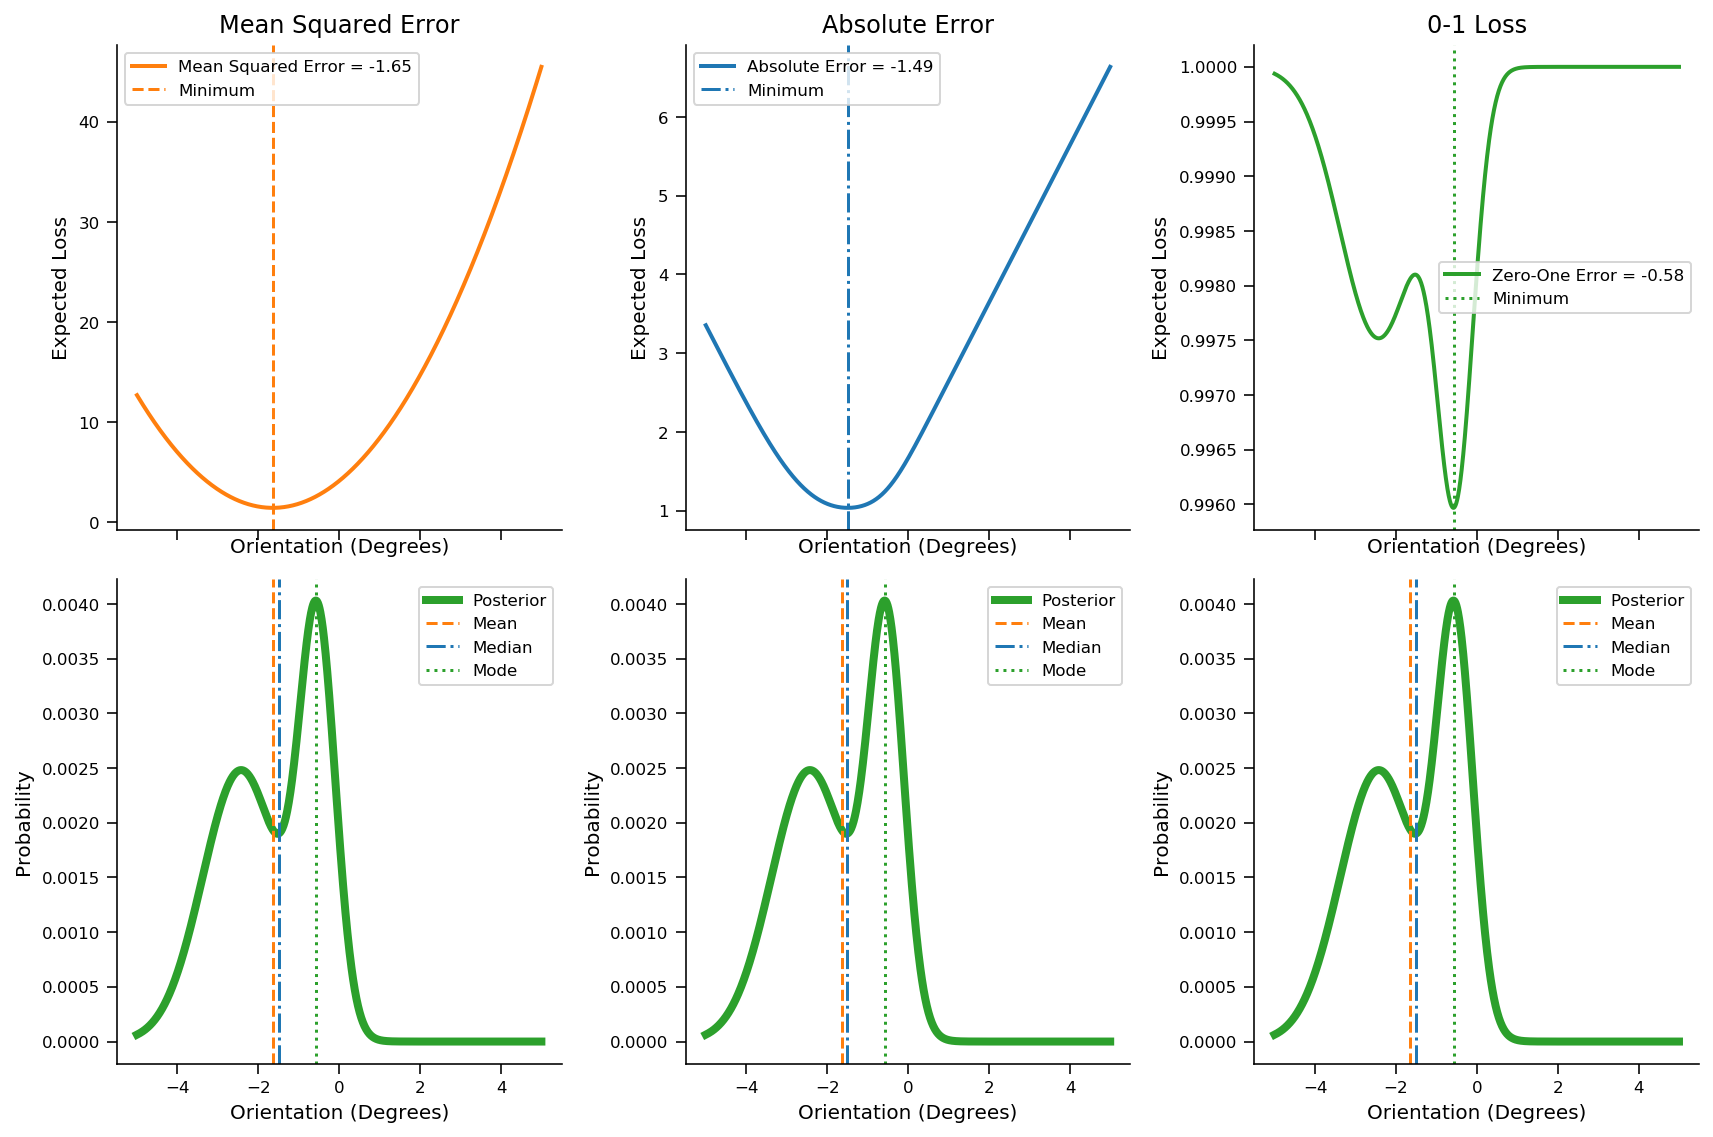

In [14]:
loss_plot_subfigures(x,
                    ExpectedLoss_MSE, min_MSE, f"Mean Squared Error = {min_MSE:.2f}",
                    ExpectedLoss_ABSE, min_ABSE, f"Absolute Error = {min_ABSE:.2f}",
                    ExpectedLoss_01, min_01, f"Zero-One Error = {min_01:.2f}")

In [ ]:
"""
The mean minimizes the mean-squared error.
Absolute error is minimized by the median, while zero-one loss is minimized
at the posterior's mode.
"""

# Section 4: Conclusion


Video available at https://youtube.com/watch?v=3nTvamDVx2s


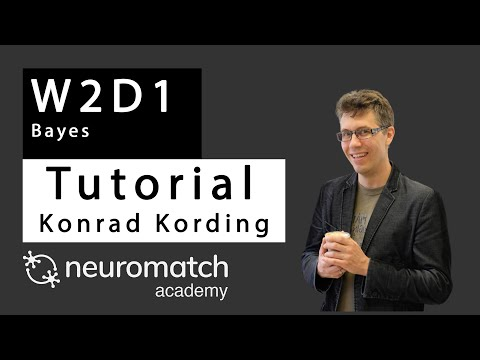

In [15]:
#@title Video 4: Outro
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='3nTvamDVx2s', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

In this tutorial, we learned about three kinds of cost functions: mean-squared error, absolute error, and zero-one loss. We used expected loss to quantify the results of making a decision, and showed that optimizing under different cost functions led us to choose different locations on the posterior. Finally, we found that these optimal locations can be identified analytically, sparing us from a brute-force search. 

Here are some additional questions to ponder:
*   Suppose your professor offered to grade your work with a zero-one loss or mean square error. 
    * When might you choose each?
    * Which would be easier to learn from?
* All of the loss functions we considered are symmetrical. Are there situations where an asymmetrical loss function might make sense? How about a negative one?







